In [39]:
# Optomechanical Noise Model of the Windchime Sensor but in Space
# Basically, no thermal noise from the spring 
#! pip install ipympl
%matplotlib ipympl

In [40]:
import json
import unittest
import time

import pylab as pl
import numpy as np
import scipy
from scipy import stats
from math import pi, sqrt, ceil, log 
from scipy.optimize import curve_fit
from scipy import constants
from numba import njit, jit
from tqdm import tqdm, trange

%matplotlib inline
import matplotlib # plotting libraries
from matplotlib import ticker, animation, rc, cm
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from mpl_toolkits.mplot3d import Axes3D

%matplotlib ipympl
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

#import plotting as pl

from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.special import kn

#jupyter labextension install @jupyter-widgets/jupyterlab-manager
#jupyter labextension install @jupyter-matplotlib

In [58]:
Q = 1e6
wo = 2*np.pi*1.94*1e14 #Hz
Qo = 1e8
v = 220e3 #m/s
wm = 1e-8 #Hz
planck_mass = 2.176434e-8 #kg
cav_len = 0.015 #m cavity length. #EVAN ASSUMPTION.
l=cav_len 
sensor_mass = 0.2 #kg
#sensor_density = 3.17*10**3 #silicon nitride
sensor_density = 19.3*10**3 #tungsten
w_m = 1e-8
Pin = 1
b = (sensor_mass/(4/3*pi*sensor_density))**(1/3)

T = 0.01 #K

pressure = 1e-15 #Pa

QNR = 10**(4.5) # 250 dB

In [42]:
(sensor_mass/(4/3*pi*sensor_density))**(1/3)

0.013524711997751414

In [43]:
# convert e based display to 10 based display 
def sci_notation(number, sig_fig=2):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    return a + " * 10^" + str(b)

#print(sci_notation(10000, sig_fig=4))
# 1.0000 * 10^4

In [44]:
#solving for individual sections of the noise model. 
                     
def shot_noise(w,Pin,wo,Qo,l=cav_len,w_m=wm,Q=Q,m=sensor_mass, use_G_opt=False, w_opt=1):
    
    h_bar = constants.hbar # checked.
    gamma = float(w_m) / float(Q) # damping. # checked. 
    m = float(m) #checked.
    k = wo/Qo #checked. 
    
    G = np.sqrt(2)*wo*np.sqrt(Pin/(h_bar*wo*k))/l # checked. 
    if use_G_opt:
        xc_opt = abs(k/(w_opt**2+(k**2)/4)) #checked
        xm_opt = abs((1/m**2)/((w_opt**2-w_m**2)**2+(gamma**2)*w_opt**2))#checked. 
        G = np.sqrt(1/(h_bar*(xc_opt)*(xm_opt)**0.5))
    abs_G = abs(G)
    
    abs_xc = abs(k/(w**2+(k**2)/4)) #checked
    abs_xm = abs((1/m**2)/((w**2-w_m**2)**2+(gamma**2)*w**2))#checked. 
    
    SN = 1/((abs_G**2)*(abs_xc)*(abs_xm))# checked.

    return SN
               
def back_action(w, Pin, wo, Qo,l=cav_len,w_m=wm,Q=Q,m=sensor_mass, use_G_opt=False, w_opt=1):
    
    h_bar = constants.hbar
    gamma = float(w_m) / float(Q)
    k = wo/Qo
    G = np.sqrt(2)*wo*np.sqrt((Pin)/(h_bar*wo*k))/l # checked. 
    #print(G)
    if use_G_opt:
        xc_opt = abs(k/(w_opt**2+(k**2)/4)) #checked
        xm_opt = abs((1/m**2)/((w_opt**2-w_m**2)**2+(gamma**2)*w_opt**2))#checked. 
        G = np.sqrt(1/(h_bar*(xc_opt)*(xm_opt)**0.5))
    abs_G = abs(G)
    
    xc = k/(w**2+(k**2)/4) # checked.
    abs_xc = abs(xc)

    BA = (h_bar**2)*(abs_G**2)*(abs_xc) #checked. 
   
    #print('BA is a ', type(BA))
    return BA
        
# mechanical thermal noise    
def thermal_noise(m, T, w_m, Q):

    k_b = float(constants.k) # Boltzmann constant
    m = float(m) # mass of sensor
    T = float(np.array(T)) # temperature Kelvin
    gamma = float(w_m) / float(Q) # damping.

    TN = 4*k_b*m*T*gamma #checked. 
    #print('TN is a', type(TN))
    return TN

def thermal_noise_gas(T, m=sensor_mass, sensor_density=sensor_density, prs=pressure):

    k_b = float(constants.k) # Boltzmann constant
    gas_mass = 6.646e-27 # mass of Helium in kg.
    T = float(np.array(T)) # temperature Kelvin
    
    sensor_radius = (sensor_mass/(4/3*np.pi*sensor_density))**(1/3)
    sensor_area = (sensor_radius**2)*np.pi
    
    TN = prs*sensor_area*np.sqrt(gas_mass*k_b*T)
    
    return TN

In [45]:
def signal_time(t, dm_mass=planck_mass, b=b, v=v, sensor_mass=sensor_mass): 
    return constants.G*dm_mass*sensor_mass*b/(b**2+v**2*t**2)**(3/2)

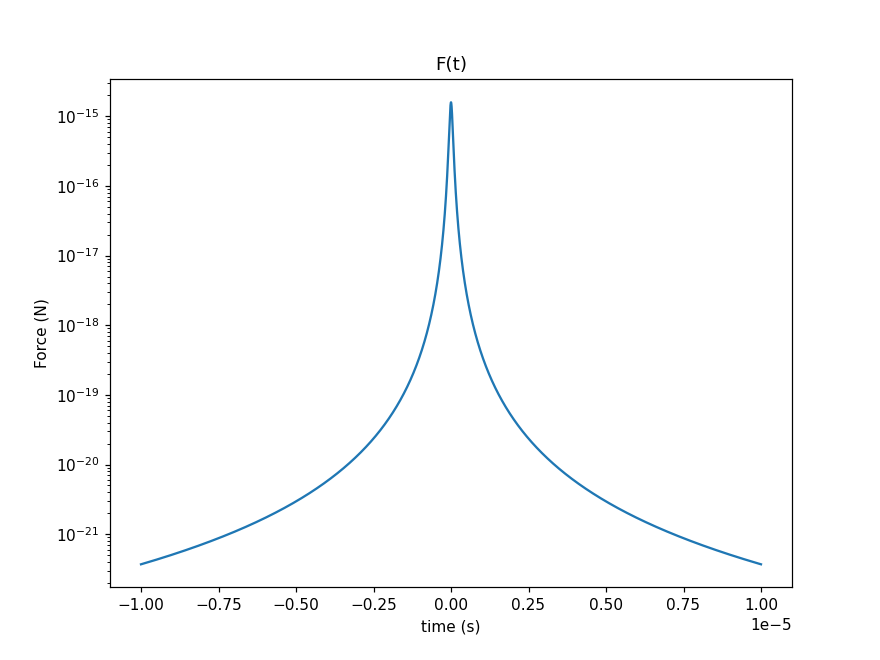

In [46]:
time = np.linspace(-1e-5, 1e-5, 1*10**6)
fig_t = plt.figure(figsize=(8,6), dpi=110)
ax_t = fig_t.add_subplot(111)
ax_t.plot(time, signal_time(time))
ax_t.set(yscale='log', xlabel='time (s)', ylabel='Force (N)', title='F(t)')
#print(time, signal_time(time))
plt.show()

In [47]:
def signal_model(w, dm_mass=planck_mass, b=b, v=v, sensor_mass=sensor_mass):
    return 2*(constants.G*dm_mass*w)**2/(np.pi*v**4)*(kn(1, w*b/v)**2)*sensor_mass**2

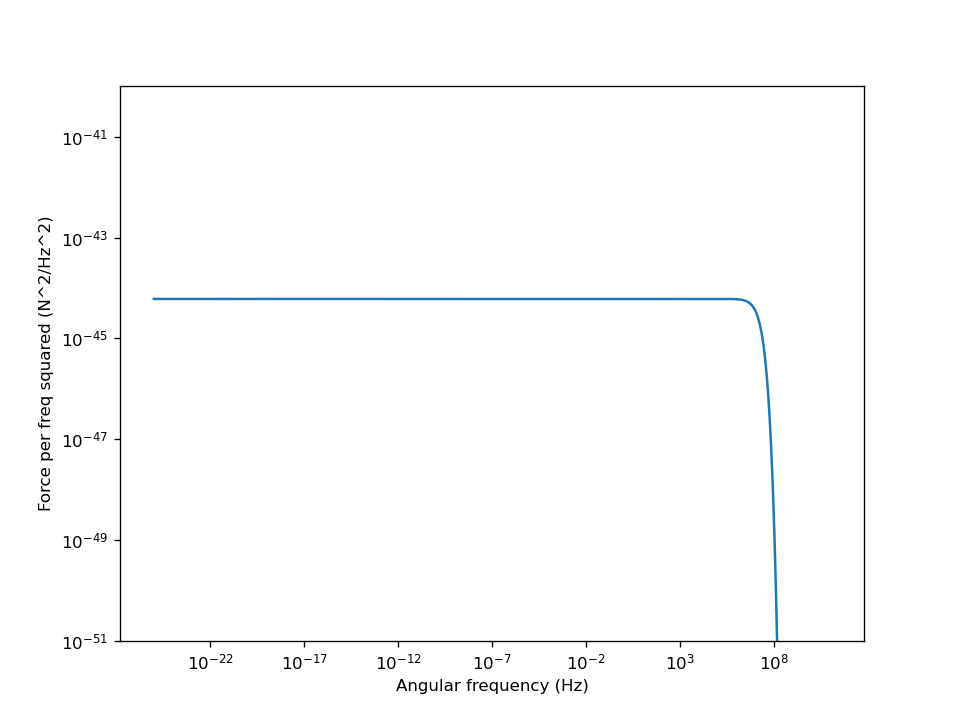

In [48]:
X = np.logspace(-25,11,10000)

fig = plt.figure(figsize=(8, 6), dpi=120)
ax = fig.add_subplot(111)
ax.plot(X, signal_model(X))
ax.set(xscale='log', yscale='log', ylabel='Force per freq squared (N^2/Hz^2)', xlabel='Angular frequency (Hz)', ylim=[1e-51, 1e-40])
plt.show()

In [49]:
def integrand_signal_model_exponential(integral_var, w_m, wo, Qo, l=cav_len, dm_mass=planck_mass, b=b, v=v, Pin=Pin,T=T, QNR=QNR, Q=Q, sensor_mass=sensor_mass, prs=pressure):
    w = np.exp(integral_var)
    N = (
        shot_noise(w, Pin, wo, Qo, l=cav_len, w_m=w_m, Q=Q, m=sensor_mass)/QNR**2 + 
        back_action(w, Pin, wo, Qo, l=cav_len, w_m=w_m, Q=Q, m=sensor_mass)/QNR**2 +
        #thermal_noise(T=T, w_m=w_m, Q=Q, m=sensor_mass) +
        thermal_noise_gas(T=T, prs=pressure)
    )
    S_sq = signal_model(w, dm_mass=dm_mass, b=b, v=v, sensor_mass=sensor_mass)
    return S_sq/N*w
    #return N

interactive(children=(FloatLogSlider(value=100000000.0, description='Q', layout=Layout(width='80%'), max=8.0, …

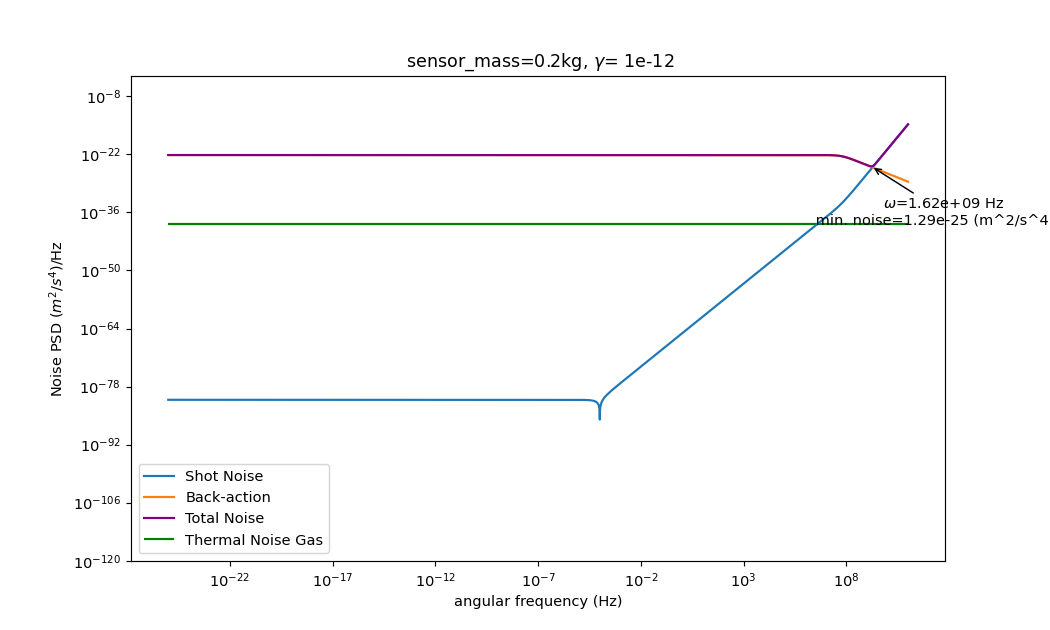

In [50]:
%matplotlib inline
%matplotlib ipympl

X = np.logspace(-25,11,10000)

fig1 = plt.figure(figsize=(10, 6), dpi=105)
ax1 = fig1.add_subplot(1, 1, 1)

def update(Q=widgets.FloatLogSlider(value=1e8,base=10,min=0,max=8,step=1e-10,description='Q', layout=widgets.Layout(width='80%')), 
           w_m=widgets.FloatLogSlider(value=1e-4,base=10,min=-4,max=10,step=1e-10, description='w_m (Hz)', layout=widgets.Layout(width='80%')),
           wo=widgets.FloatLogSlider(value=2*np.pi*1.94*10e14,base=10,min=11,max=19,step=1e-10,description='w_0 (Hz)', layout=widgets.Layout(width='80%')),
           Qo=widgets.FloatLogSlider(value=10*10e6,base=10,min=2,max=10,step=1e-10,description='Q_0', layout=widgets.Layout(width='80%')),
           T=widgets.FloatSlider(value=0.01,min=0.01,max=400,step=0.01,description='T (K)', layout=widgets.Layout(width='80%')),
           Pin=widgets.FloatLogSlider(value=1,base=10,min=-5,max=14,step=1e-10,description='P_input (W)', layout=widgets.Layout(width='80%')),
           pressure=widgets.FloatLogSlider(value=1e-10,base=10,min=-15,max=-5,step=1e-10,description='pressure (Pa)', layout=widgets.Layout(width='80%')),
           cav_len=widgets.FloatLogSlider(value=1e-10,base=10,min=-15,max=5,step=1e-10,description='cavity length (m)', layout=widgets.Layout(width='80%'))
           ):
    
    ax1.clear()
    ax1.set(xscale='log',yscale='log', ylabel='Noise PSD ($m^2$/$s^4$)/Hz', xlabel='angular frequency (Hz)', title=' sensor_mass='+str(sensor_mass)+'kg, $\gamma$= '+str(float('{:.6e}'.format(w_m/Q))))
    ax1.set_ylim([1e-120, 1e-3])
    
    SN = shot_noise(X, Pin, wo, Qo, l=cav_len, w_m=w_m, Q=Q, use_G_opt=False, w_opt=1e6)/QNR**2
    BA = back_action(X, Pin, wo, Qo, l=cav_len, w_m=w_m, Q=1e4, use_G_opt=False, w_opt=1e6)/QNR**2 
    #TN = thermal_noise(m=sensor_mass, T=T, w_m=w_m, Q=Q)
    TNG = thermal_noise_gas(T=T, prs=pressure)
    
    total_noise = SN+BA+TNG
    
    ax1.plot(X, SN, label='Shot Noise')
    ax1.plot(X, BA, label='Back-action')
    #ax1.hlines(TN, xmin=X[0],xmax=X[-1], color='red', label='Thermal Noise')
    ax1.hlines(TNG,xmin=X[0],xmax=X[-1], color='green', label='Thermal Noise Gas')
    ax1.plot(X, total_noise, color='purple', label='Total Noise')
    
    print(pressure, TNG)
    
    ax1.legend()
    label = '$\omega$=' + '{:.2e}'.format(X[np.argmin(total_noise)]) + ' Hz \n min. noise='+'{:.2e}'.format(min(total_noise))+' (m^2/s^4)/Hz'
    ax1.annotate(label, (X[np.argmin(total_noise)], min(total_noise)), textcoords="offset points", xytext=(50,-40), ha='center',arrowprops=dict(arrowstyle="->"))
    # print("SN vs. w = ", shot_noise(X, 1, w_m=w_m, Q=Q, use_G_opt=True, w_opt=1e6))
    #fig.canvas.draw_idle()
    
    #print('min. freq.=', X[np.argmin(total_noise)], 'Hz, min. noise=', min(total_noise), '(m^2/s^4)/Hz') 
    
interact(update);

interactive(children=(FloatLogSlider(value=100000000.0, description='Q', layout=Layout(width='80%'), max=8.0, …

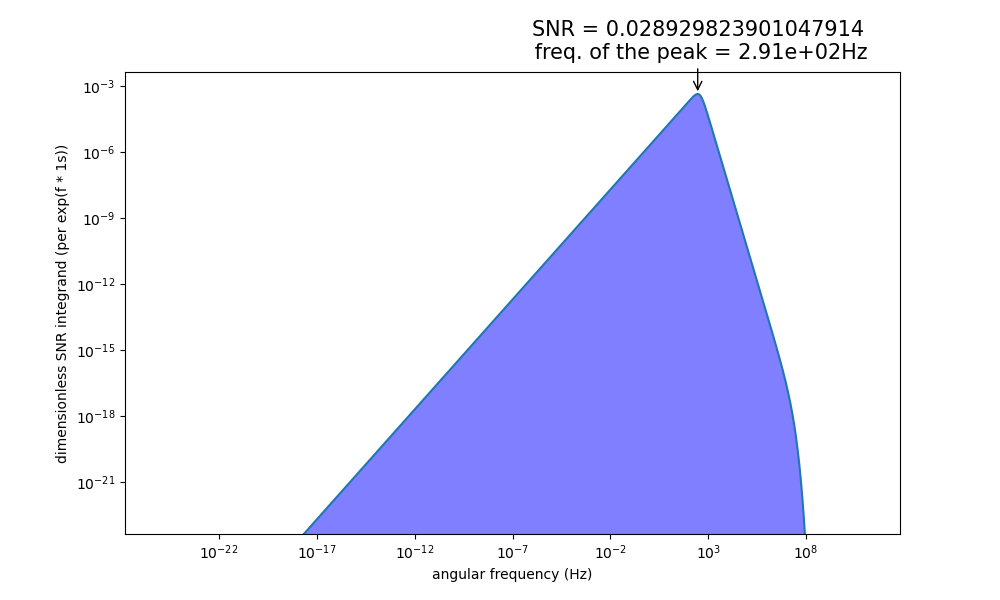

In [52]:
fig2 = plt.figure(figsize=(10, 6), dpi=100)
ax2 = fig2.add_subplot(1, 1, 1)   

log_x = np.linspace(-25/np.log10(np.e), 11/np.log10(np.e), 10000)
x = np.exp(log_x)

def update(Q=widgets.FloatLogSlider(value=1e8,base=10,min=0,max=8,step=1e-10,description='Q', layout=widgets.Layout(width='80%')), 
           w_m=widgets.FloatLogSlider(value=1,base=10,min=-4,max=10,step=1e-10, description='w_m (Hz)', layout=widgets.Layout(width='80%')),
           wo=widgets.FloatLogSlider(value=2*np.pi*1.94*10e14,base=10,min=11,max=19,step=1e-10,description='w_0 (Hz)', layout=widgets.Layout(width='80%')),
           Qo=widgets.FloatLogSlider(value=10*10e6,base=10,min=2,max=10,step=1e-10,description='Q_0', layout=widgets.Layout(width='80%')),
           T=widgets.FloatSlider(value=0.01,min=0.01,max=400,step=0.01,description='T (K)', layout=widgets.Layout(width='80%')),
           Pin=widgets.FloatLogSlider(value=1,base=10,min=-5,max=14,step=1e-10,description='P_input (W)', layout=widgets.Layout(width='80%')),
           #pressure=widgets.FloatLogSlider(value=1e-10,base=10,min=-15,max=-5,step=1e-10,description='pressure (Pa)', layout=widgets.Layout(width='80%'))
           ):
    
    ax2.clear()
    signal = integrand_signal_model_exponential(log_x, w_m, wo, Qo, l=cav_len, dm_mass=planck_mass, b=b, v=v, Pin=Pin,T=T, QNR=QNR, Q=Q, sensor_mass=sensor_mass, prs=pressure)
    ax2.plot(x, signal)
    ax2.set(xscale='log', yscale='log', xlabel='angular frequency (Hz)', ylabel='dimensionless SNR integrand (per exp(f * 1s))', ylim=[np.max(signal)*1e-20, np.max(signal)*10])

    SNR_squared = quad(integrand_signal_model_exponential, -30, 40, args=(w_m, wo, Qo, cav_len, planck_mass, b, v, Pin, T, QNR, Q, sensor_mass, pressure))
    SNR = np.sqrt(SNR_squared)
    
    label = 'SNR = ' + str(SNR[0]) + '\n freq. of the peak = ' + '{:.2e}'.format(X[np.argmax(signal)]) + 'Hz'
    ax2.annotate(label, (X[np.argmax(signal)], max(signal)), textcoords="offset points", xytext=(0,25), ha='center', fontsize=15, arrowprops=dict(arrowstyle="->")) 

    ax2.fill(X, signal, facecolor='blue', alpha=0.5)
    
    #print('SNR, err =', SNR)
    
interact(update);

In [53]:
initial_guess=(w_m, wo, Qo, cav_len, planck_mass, b, v, Pin, T, QNR, Q, sensor_mass)
quad(integrand_signal_model_exponential, -30, 40, args=initial_guess)

(0.00026466208026699957, 2.331679391451758e-10)

In [54]:
def integrand_signal_model_exponential_2(integral_var, arg):
    w = np.exp(integral_var)
    dm_mass = planck_mass
    Pin, wo, Qo = arg 
    N = (
        shot_noise(w, Pin, wo, Qo, l=cav_len, w_m=w_m, Q=Q, m=sensor_mass)/QNR**2 + 
        back_action(w, Pin, wo, Qo, l=cav_len, w_m=w_m, Q=Q, m=sensor_mass)/QNR**2 +
        #thermal_noise(T=T, w_m=w_m, Q=Q, m=sensor_mass) +
        thermal_noise_gas(T=T, prs=pressure)
    )
    S_sq = signal_model(w, dm_mass=dm_mass, b=b, v=v, sensor_mass=sensor_mass)
    return S_sq/N*w

In [55]:
def my_func(args):
    
    result=-quad(integrand_signal_model_exponential_2, -30, 40, args=args)[0]
    return result

In [56]:
# QNR_list = np.logspace(3, 6, 7)
# initial_guess=(Pin, wo, Qo)
# bounds=((1e-12, 1), (1e11, 1e19), (1e2, 1e10))
# optimal_SNR_sq = np.zeros(len(QNR_list))
# optimal_Pin = np.zeros(len(QNR_list))
# optimal_wo = np.zeros(len(QNR_list))
# optimal_Qo = np.zeros(len(QNR_list))

# for i in trange(len(QNR_list)):
#     QNR = QNR_list[i]
#     max_integral = scipy.optimize.minimize(my_func, initial_guess, method='Nelder-Mead')
#     optimal_SNR_sq[i] = max_integral.fun   
#     optimal_Pin[i] = max_integral.x[0]
#     optimal_wo[i] = max_integral.x[1]
#     optimal_Qo[i] = max_integral.x[2]
    
# print(max_integral.fun)    

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\holin\AppData\Local\Temp/ipykernel_23676/2920371575.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  k = wo/Qo #checked.
C:\Users\holin\AppData\Local\Temp/ipykernel_23676/2920371575.py:17: RuntimeWarning: invalid value encountered in double_scalars
  abs_xc = abs(k/(w**2+(k**2)/4)) #checked
C:\Users\holin\AppData\Local\Temp/ipykernel_23676/2920371575.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  k = wo/Qo
C:\Users\holin\AppData\Local\Temp/ipykernel_23676/2920371575.py:37: RuntimeWarning: invalid value encountered in double_scalars
  xc = k/(w**2+(k**2)/4) # checked.
C:\Users\holin\AppData\Local\Temp/ipykernel_23676/2093507272.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result=-quad(integra

-6.902447984076398


sensor_mass = 0.2 kg
sensor_density = 19300.0 kg/m^3 (Tungsten) 
mechanical freq. w_m = 1e-08 Hz
mechanical quality factor Q = 1000000.0 
input laser power P_in = 1 W
cavity length l = 0.015 m
dark matter mass = 2.176e-08 kg
impact parameter b = 0.0135 m
temperature= 0.01 K
pressure= 1e-15 Pa


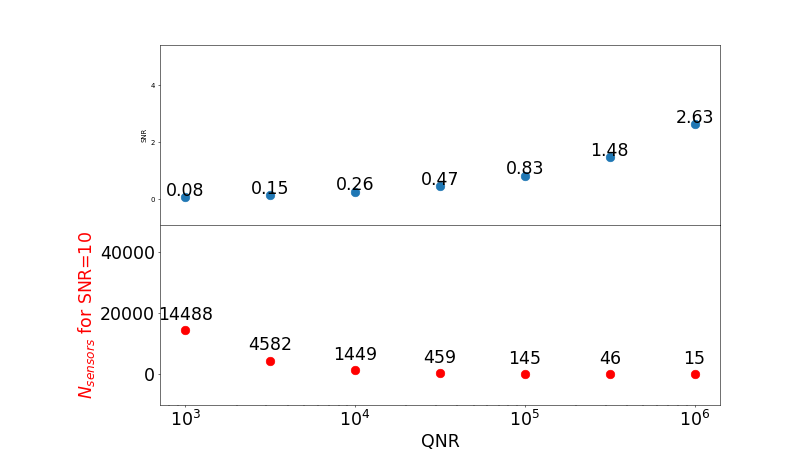

In [59]:
optimal_SNR = np.sqrt(abs(optimal_SNR_sq))
fig3  = plt.figure(figsize=(16, 9), dpi=50);
ax3 = fig3.add_subplot(211);  

print('sensor_mass =', sensor_mass, 'kg\nsensor_density =', sensor_density, 'kg/m^3 (Tungsten) \nmechanical freq. w_m =', w_m, 'Hz\nmechanical quality factor Q =', Q, '\ninput laser power P_in =', Pin, 'W\ncavity length l =', l, 'm\ndark matter mass =', "{:.3e}".format(planck_mass), 'kg\nimpact parameter b =', "{:.4f}".format(b), 'm\ntemperature=', T, 'K\npressure=', pressure, 'Pa');

ax3.clear();
ax3.scatter(QNR_list, optimal_SNR, s=150); 
#ax3.set(xscale='log', xlabel='QNR', ylabel='SNR', ylim=[-0.9, 5.4], title='QNR Dependence of SNR (Top) and Required $N_{sensor}$ to Obtain SNR=10 (Bottom)');
ax3.set(xscale='log', xlabel='QNR', ylabel='SNR', ylim=[-0.9, 5.4], title='');
#ax3.set_xticks(np.logspace(3, 6, 4));
ax3.xaxis.set_visible(False);
plt.rcParams['font.size'] = '25'

for x,y in zip(QNR_list, optimal_SNR):
    label = "{:.2f}".format(y)
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0, 2), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
n_sensor_good = (10/optimal_SNR)**2 # number of sensors required to obtain SNR=10   
    
ax4 = fig3.add_subplot(212);   
ax4.scatter(QNR_list, n_sensor_good, color='red', s=150);
yvalues = plt.gca().get_yticks()
ax4.set(xscale='log', xlabel='QNR', ylim=[-1e4, 4.9e4])
ax4.set_ylabel('$N_{sensors}$ for SNR=10', color='red')
#ax4.set_xticks(np.logspace(3, 6, 4));
#ax4.set_xticklabels()
plt.rcParams['font.size'] = '25'
plt.rcParams['axes.formatter.useoffset'] = False

for x,y in zip(QNR_list, n_sensor_good):
    label = "{:.0f}".format(ceil(y))
    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0, 15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
    
#ax4.tick_params(axis='y', labelcolor='red')
plt.subplots_adjust(left=0.2,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0)
#plt.gca().set_yticklabels(['{:.0f}'.format(j) for j in yvalues])
plt.show()

In [60]:
Q_list = np.geomspace(1e0, 1e8, 9)
m_list = np.geomspace(1e-5, 1e3, 9)
pressure_list = np.geomspace(1e-5, 1e-15, 11)
l_list = np.geomspace(1e-5, 1e5, 11)
T_list = np.geomspace(1e-3, 1e3, 7)

QNR_list = np.logspace(3, 6, 7)

initial_guess=(Pin, wo, Qo)
bounds=((1e-12, 1), (1e11, 1e19), (1e2, 1e10))
optimal_SNR_sq_1 = np.zeros((len(m_list), len(QNR_list))) # m vs. QNR
optimal_SNR_sq_2 = np.zeros((len(pressure_list), len(QNR_list))) # pressure vs. QNR
optimal_SNR_sq_3 = np.zeros((len(l_list), len(QNR_list)))
optimal_SNR_sq_4 = np.zeros((len(T_list), len(QNR_list)))
#optimal_Pin = np.zeros(len(QNR_list))
#optimal_wo = np.zeros(len(QNR_list))
#optimal_Qo = np.zeros(len(QNR_list))

for i in trange(len(m_list)):
    sensor_mass = m_list[i]
    for j in trange(len(QNR_list)):
        QNR = QNR_list[j]
        max_integral = scipy.optimize.minimize(my_func, initial_guess, method='Nelder-Mead')
        optimal_SNR_sq_1[i][j] = max_integral.fun
        #optimal_Pin[i] = max_integral.x[0]
        #optimal_wo[i] = max_integral.x[1]
        #optimal_Qo[i] = max_integral.x[2]
sensor_mass = 0.2 #kg

for i in trange(len(pressure_list)):
    pressure = pressure_list[i]
    for j in trange(len(QNR_list)):
        QNR = QNR_list[j]
        max_integral = scipy.optimize.minimize(my_func, initial_guess, method='Nelder-Mead')
        optimal_SNR_sq_2[i][j] = max_integral.fun
pressure = 1e-15

for i in trange(len(l_list)):
    cav_len = l_list[i] 
    for j in trange(len(QNR_list)):
        QNR = QNR_list[j]
        max_integral = scipy.optimize.minimize(my_func, initial_guess, method='Nelder-Mead')
        optimal_SNR_sq_3[i][j] = max_integral.fun
cav_len = 0.015        
        
for i in trange(len(T_list)):
    T = T_list[i] 
    for j in trange(len(QNR_list)):
        QNR = QNR_list[j]
        max_integral = scipy.optimize.minimize(my_func, initial_guess, method='Nelder-Mead')
        optimal_SNR_sq_4[i][j] = max_integral.fun
T = 0.01

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\holin\AppData\Local\Temp/ipykernel_23676/2920371575.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  k = wo/Qo #checked.
C:\Users\holin\AppData\Local\Temp/ipykernel_23676/2920371575.py:17: RuntimeWarning: invalid value encountered in double_scalars
  abs_xc = abs(k/(w**2+(k**2)/4)) #checked
C:\Users\holin\AppData\Local\Temp/ipykernel_23676/2920371575.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  k = wo/Qo
C:\Users\holin\AppData\Local\Temp/ipykernel_23676/2920371575.py:37: RuntimeWarning: invalid value encountered in double_scalars
  xc = k/(w**2+(k**2)/4) # checked.
C:\Users\holin\AppData\Local\Temp/ipykernel_23676/2093507272.py:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  result=-quad(integra

 29%|████████████████████████                                                            | 2/7 [00:02<00:07,  1.46s/it]


 57%|████████████████████████████████████████████████                                    | 4/7 [00:08<00:07,  2.38s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:13<00:00,  1.97s/it]


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:38<00:00, 14.09s/it]


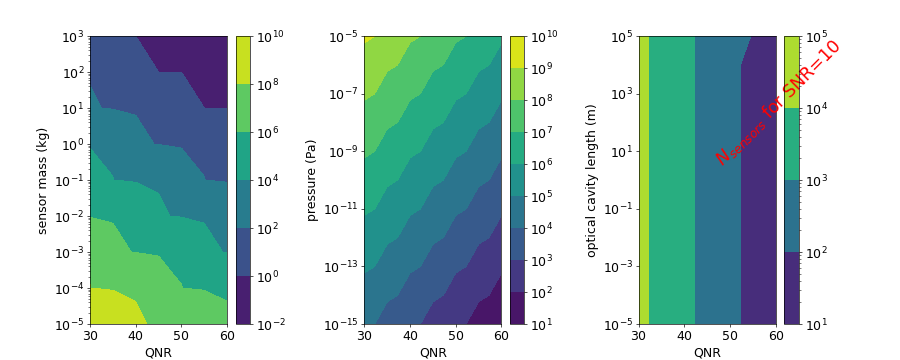

In [71]:
optimal_SNR_1 = np.sqrt(abs(optimal_SNR_sq_1))
optimal_SNR_2 = np.sqrt(abs(optimal_SNR_sq_2))
optimal_SNR_3 = np.sqrt(abs(optimal_SNR_sq_3))

n_sensor_good_1 = (10/optimal_SNR_1)**2
for i in range(len(n_sensor_good_1)):
    for j in range(len(n_sensor_good_1[0])):
        if n_sensor_good_1[i][j] < 1:
            n_sensor_good_1[i][j] = 1
    
n_sensor_good_2 = (10/optimal_SNR_2)**2
for i in range(len(n_sensor_good_2)):
    for j in range(len(n_sensor_good_2[0])):
        if n_sensor_good_2[i][j] < 1:
            n_sensor_good_2[i][j] = 1
            
n_sensor_good_3 = (10/optimal_SNR_3)**2
for i in range(len(n_sensor_good_3)):
    for j in range(len(n_sensor_good_3[0])):
        if n_sensor_good_3[i][j] < 1:
            n_sensor_good_3[i][j] = 1

fig, axes = pl.subplots(1, 3, figsize=(15, 6), dpi=60)
axes[0].set_ylabel('sensor mass (kg)')
#axes[0].set_title('$N_{sensors}$ for SNR=10', color='red')
axes[0].set_xlabel('QNR')
axes[0].set_yscale('log')
axes[1].set_ylabel('pressure (Pa)')
axes[1].set_xlabel('QNR')
axes[1].set_yscale('log')
axes[2].set_ylabel('optical cavity length (m)')
axes[2].set_xlabel('QNR')
axes[2].set_yscale('log')
c1 = axes[0].contourf(10*np.log10(QNR_list), m_list, n_sensor_good_1, locator=ticker.LogLocator())
c2 = axes[1].contourf(10*np.log10(QNR_list), pressure_list, n_sensor_good_2, locator=ticker.LogLocator()) 
c3 = axes[2].contourf(10*np.log10(QNR_list), l_list, n_sensor_good_3, locator=ticker.LogLocator())

#cb1 = pl.colorbar(c1, ax=axes[0], location='top', orientation='horizontal')
cb1 = pl.colorbar(c1, ax=axes[0])
cb2 = pl.colorbar(c2, ax=axes[1])
cb3 = pl.colorbar(c3, ax=axes[2])
cb3.set_label('$N_{sensors}$ for SNR=10', color='red', loc='top', rotation=45, size=21)
cb3.ax.tick_params(labelsize=15) 

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.4)
plt.show()

plt.rcParams['font.size'] = '15'
plt.rcParams['axes.formatter.useoffset'] = False

# optical freq. and temperature

In [72]:
n_sensor_good_1

array([[1.50961187e+09, 4.77381061e+08, 1.50961147e+08, 4.77381061e+07,
        1.50961146e+07, 4.77381061e+06, 1.50961147e+06],
       [1.02848673e+08, 3.25235931e+07, 1.02848632e+07, 3.25235931e+06,
        1.02848632e+06, 3.25235931e+05, 1.02848632e+05],
       [7.00699572e+06, 2.21580660e+06, 7.00699572e+05, 2.21580660e+05,
        7.00699572e+04, 2.21580660e+04, 7.00699572e+03],
       [4.77381061e+05, 1.50961147e+05, 4.77381061e+04, 1.50961147e+04,
        4.77381061e+03, 1.50961147e+03, 4.77381061e+02],
       [3.25235931e+04, 1.02848632e+04, 3.25235931e+03, 1.02848632e+03,
        3.25235931e+02, 1.02848632e+02, 3.25235931e+01],
       [2.21580660e+03, 7.00699572e+02, 2.21580660e+02, 7.00699572e+01,
        2.21580660e+01, 7.00699572e+00, 2.21580660e+00],
       [1.50961147e+02, 4.77381061e+01, 1.50961147e+01, 4.77381061e+00,
        1.50961147e+00, 1.00000000e+00, 1.00000000e+00],
       [1.02848632e+01, 3.25235931e+00, 1.02848632e+00, 1.00000000e+00,
        1.00000000e+00, 1